FTP 모델이 어떠한 가중치를 갖고 있는지 확인용
(MIT-BIH를 위해 ver6의 코드가 사용됨)

In [1]:
# 사전 변수
checkpoint_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_filter_CNN_IF_str16_2025-01-03-11-53-42_fold1_lastEpoch.pt"
config_json_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver6/SNN_MLP_ver6_filter_CNN_IF_str16_2025-01-03-11-53-42_fold1_config.json"


savefile_all = "./result_all.svg"
savefile_one = "./result_one.svg"



In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

import argparse

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-06-02 07:19:22.307076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 07:19:22.360634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 07:19:23.171388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# argparse 등의 config 분해용 코드
def load_json(path):
    with open(path) as data_file:
        param = json.load(data_file)

    return param

param = load_json(config_json_dir)
args = param

print(args)

{'cuda_gpu': 3, 'model_name': 'SNN_MLP_ver6_filter_CNN_IF_str16', 'num_classes': 2, 'num_encoders': 64, 'early_stop': 25, 'early_stop_enable': False, 'init_lr': 0.001, 'batch_size': 256, 'num_epochs': 1000, 'train_path': '/home/hschoi/data/MIT-BIH/mitbih_train.csv', 'test_path': '/home/hschoi/data/MIT-BIH/mitbih_test.csv', 'class_weight': [1.0, 4.0], 'hidden_size': 1024, 'hidden_size_2': 1024, 'encoder_min': 0.2, 'encoder_max': 2.0, 'scheduler_tmax': 5, 'scheduler_eta_min': 1e-05, 'encoder_requires_grad': True, 'encoder_type': 'filter', 'encoder_tp_iter_repeat': 3, 'encoder_filter_kernel_size': 32, 'encoder_filter_stride': 16, 'encoder_filter_padding': 0, 'encoder_filter_channel_size': 1024, 'random_seed': 999, 'checkpoint_save': True, 'checkpoint_path': '/home/hschoi/data/leehyunwon/ECG-SNN/', 'threshold_value': 1.0, 'reset_value_residual': False, 'need_bias': True, 'k_folds': 5}


In [4]:
# ver6 환경에 맞춰 args를 수정
cuda_gpu = args['cuda_gpu']
model_name = args['model_name']
num_classes = args['num_classes']
num_encoders = args['num_encoders']
early_stop = args['early_stop']
early_stop_enable = args['early_stop_enable']
learning_rate = args['init_lr']
batch_size = args['batch_size']
num_epochs = args['num_epochs']
train_path = args['train_path']
test_path = args['test_path']
class_weight = args['class_weight']
encoder_min = args['encoder_min']
encoder_max = args['encoder_max']
hidden_size = args['hidden_size']
hidden_size_2 = args['hidden_size_2']
scheduler_tmax = args['scheduler_tmax']
scheduler_eta_min = args['scheduler_eta_min']
encoder_requires_grad = args['encoder_requires_grad']
encoder_type = args['encoder_type']
encoder_tp_iter_repeat = args['encoder_tp_iter_repeat']
encoder_filter_kernel_size = args['encoder_filter_kernel_size']
encoder_filter_stride = args['encoder_filter_stride']
encoder_filter_padding = args['encoder_filter_padding']
encoder_filter_channel_size = args['encoder_filter_channel_size'] # CNN 스타일로 가려면 채널갯수로 깊게 분석해야 할 것이다.
random_seed = args['random_seed']
checkpoint_save = args['checkpoint_save']
checkpoint_path = args['checkpoint_path']
threshold_value = args['threshold_value']
reset_value_residual = args['reset_value_residual']
need_bias = args['need_bias']
k_folds = args['k_folds']

In [5]:
# cuda 환경 사용
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_gpu)  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용

# 랜덤시드 고정
seed = random_seed
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device :cuda


In [6]:
############################################ FTP 방식 ############################################
class filter_CNN(nn.Module):
    def __init__(self, num_classes, hidden_size, hidden_size_2, out_channels, kernel_size, stride, padding, threshold_value, bias_option, reset_value_residual):
        super().__init__()
        
        # CNN 인코더 필터 : 이건 그냥 갈긴다.
        self.cnn_encoders = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=bias_option) # 여기도 bias가 있다 함
        
        # CNN 인코더 IF뉴런 : 이거 추가해서 인코더 완성하기
        self.cnn_IF_layer = neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value)
        
        # SNN 리니어 : 인코더 입력 -> 히든
        self.hidden = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(out_channels, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

    def forward(self, x: torch.Tensor):
        results = 0. # for문이 모델 안에 있으므로 밖에다가는 이녀석을 내보내야 함
        
        # CNN 필터는 채널 차원이 추가되므로 1번 쪽에 채널 차원 추가
        x = x.unsqueeze(1)
        # CNN 필터 통과시키기
        x = self.cnn_encoders(x)
        # print(x.shape)
        timestep_size = x.shape[2]
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 채널, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,:,i].squeeze() # 이러면 출력크기 차원이 사라지고 (배치, 채널)만 남겠지?
            x_slice = self.cnn_IF_layer(x_slice) # CNN 필터 이후 IF 레이어 거치기
            x_slice = self.hidden(x_slice)
            # x_slice = self.hidden_2(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        # results = torch.stack(results, dim=0) # 텐서로 바꾸기
        return results / timestep_size

In [7]:
# 모델 불러다가 .pt에 맞춰서 넣기 : 일단 FordA 데이터셋으로 학습된 모델을 쓰지만, 데이터로더는 여기선 필요없음

# 임시 : args 변경
args_original = args
# args = args['model'] # 일단 여기선 안씀씀

# SNN 네트워크 초기화
model = filter_CNN(num_classes = num_classes, hidden_size=hidden_size, hidden_size_2=hidden_size_2, 
            out_channels=encoder_filter_channel_size, kernel_size=encoder_filter_kernel_size, 
            stride=encoder_filter_stride, padding=encoder_filter_padding, threshold_value=threshold_value, 
            bias_option=need_bias, reset_value_residual=reset_value_residual).to(device=device)

# args 원복
args = args_original

# 모델 로드 함수 정의
def load_model(checkpoint_path_, model):
    checkpoint = torch.load(checkpoint_path_)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 평가 모드로 전환
    return model


# 모델에 가중치 넣기
model = load_model(checkpoint_dir, model)

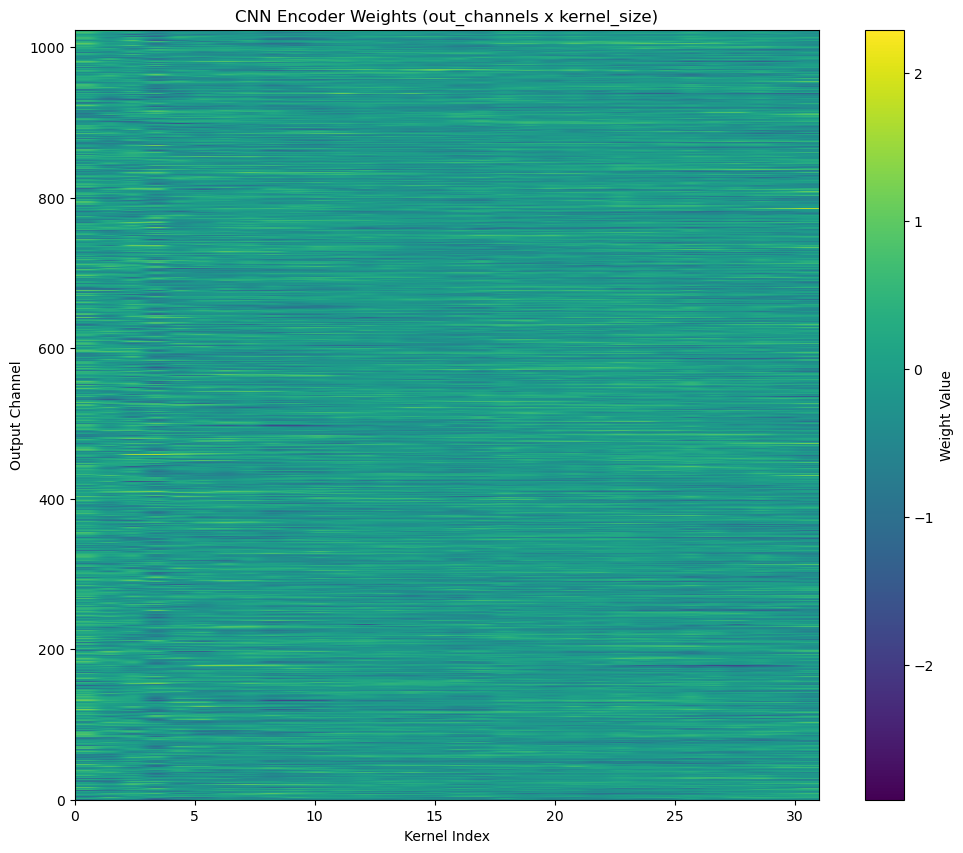

In [8]:
# cnn_encoders 가중치 가져오기
weights = model.cnn_encoders.weight.detach().cpu().numpy()  # (out_channels, in_channels, kernel_size)

# in_channels == 1 이므로 squeeze
if weights.shape[1] == 1:
    weights = weights.squeeze(1)  # (out_channels, kernel_size)

# 히트맵으로 플롯
plt.figure(figsize=(12, 10))
plt.imshow(weights, cmap='viridis', aspect='auto', extent=[0, weights.shape[1]-1, 0, weights.shape[0]-1])
plt.colorbar(label='Weight Value')
plt.xlabel('Kernel Index')
plt.ylabel('Output Channel')
plt.title('CNN Encoder Weights (out_channels x kernel_size)')
plt.savefig(savefile_all, format="svg", bbox_inches="tight")
plt.show()

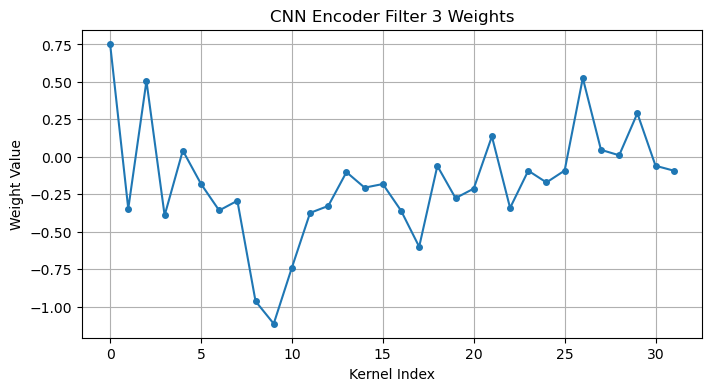

In [11]:
# cnn_encoders 가중치 가져오기
weights = model.cnn_encoders.weight.detach().cpu().numpy()  # (out_channels, in_channels, kernel_size)

# in_channels == 1 이므로 squeeze
if weights.shape[1] == 1:
    weights = weights.squeeze(1)  # (out_channels, kernel_size)

filter_idx = 3  # 원하는 필터 인덱스

plt.figure(figsize=(8, 4))
plt.plot(weights[filter_idx], marker='o', markersize=4)
plt.xlabel('Kernel Index')
plt.ylabel('Weight Value')
plt.title(f'CNN Encoder Filter {filter_idx} Weights')
plt.grid(True)
plt.savefig(savefile_one, format="svg", bbox_inches="tight")
plt.show()
